In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import ip2geotools
import ip2geotools.databases.noncommercial as dbs

Nodes of graph: 
213
Edges of graph: 
314
Filtered IPs: 64
{'172.21.18.126': {'weight': 0}, '181.198.150.1': {'weight': 0}, '172.20.10.1': {'weight': 0}, '192.168.86.1': {'weight': 0}, '200.63.218.97': {'weight': 0}, '100.98.8.1': {'weight': 0}, '181.198.130.1': {'weight': 0}, '72.14.234.8': {'weight': 0}, '104.27.181.97': {'weight': 0}, '209.85.143.102': {'weight': 0}, '186.4.244.1': {'weight': 0}, '100.97.32.1': {'weight': 0}, '157.100.244.1': {'weight': 0}, '10.0.0.1': {'weight': 0}, '186.46.4.225': {'weight': 0}, '186.101.152.1': {'weight': 0}, '186.4.145.1': {'weight': 0}, '100.96.233.1': {'weight': 0}, '200.63.218.177': {'weight': 0}, '100.98.68.1': {'weight': 0}, '186.101.137.1': {'weight': 0}, '181.198.191.129': {'weight': 0}, '186.46.4.174': {'weight': 0}, '186.46.4.226': {'weight': 0}}


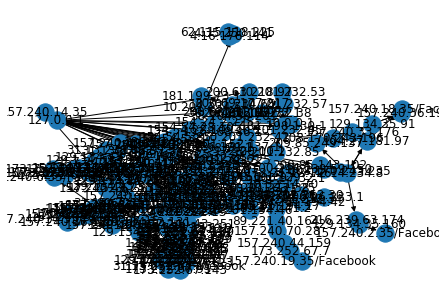

In [2]:
site_name = 'Facebook'
start_ip = '127.0.0.1'

#Path de lectura de archivos generados con traceroute.py
path = './All'

#lista todos los archivos dentro de la carpeta definida en path
files = os.listdir(path)

#diccionario que guarda los edges y sus frecuencias/pesos de los caminos mas comunes.
edge_dict = {}

#Grafo dirigido que tendra todas las rutas que siguieron los paquetes.
G = nx.DiGraph()

#contado de ips filtradas
filtered_counter = 0

#forloop usado para leer todos los archivos listados en el path.

for file_name in files:

    file_name_pieces = file_name.split('.')
    
    #Saltamos este archivo si no corresponde al IP estudiado
    if site_name not in file_name_pieces[1]: 
        continue
    
    fd =  open(path+'/'+file_name, 'r')
    file = fd.read()
    file_split = file.split('\n')
    len_file_split = len(file_split)

    destination = ''
    prev = ''

    #ips que vamos a filtrar de los tres primeros registros de cada archivo que vamos a analizar.
    #¿qué son estos ips?
    filter_ip = ['192.168.100.1', '192.168.10.1', '192.168.1.1',
                 '10.0.2.2', '192.168.0.1','172.21.140.1','192.168.4.1',
                 '192.168.0.254', '192.168.10.1', '192.168.1.10']

    #ip de destino que se encuentra en la primera linea del archivo generado por traceroute.py
    destination = file_split[0].rstrip('\r')

    #forloop para iterar todas las entradas del archivo generado por traceroute.py desde el primer registro del tipo 1\tIP.
    for i in range(1, len_file_split-1):
        split_line = file_split[i].split('\t')
        curr = split_line[1]
        curr = curr.rstrip('\r')

        #filtrado de cualquier current ip que no sea una ip valida.
        if curr != '*':

            #filtrado de aquellas ips en filter_ip que esten en las primeras tres lineas del archivo.
            if (i == 1 or i == 2 or i == 3) and (curr in filter_ip):
                filtered_counter = filtered_counter + 1
            else:
                #agrega los edges al diccionario que llevan al destino
                if curr == destination and prev != '':
                    edge = (prev, destination.rstrip('\r') + '/' + file_name_pieces[1])
                    if edge in edge_dict:
                        edge_dict[edge] = edge_dict[edge] + 1
                    else:
                        edge_dict[edge] = 1
                else:
                    #agrega los edges de aquellos edges que no llevan a destino
                    #en el if / positivo -> agrega toda ip seguida de otra ip en el camino del traceroute.
                    if prev != '':
                        edge = (prev, curr)
                        if edge in edge_dict:
                            edge_dict[edge] = edge_dict[edge] + 1
                        else:
                            edge_dict[edge] = 1
                    else:
                        #agrega el nodo especial que vamos a llamar 127.0.0.1 desde el cual vamos a buscar el camino mas corto.
                        if curr != destination and prev == '':
                            edge = (start_ip, curr)
                            if not edge in edge_dict:
                                edge_dict[edge] = 0
                    prev = curr

#Se agregan todos los edges y nodos al grafo
for key, value in edge_dict.items():
    if value == 0:
        G.add_edge(key[0], key[1], weight=0)
    else:
        G.add_edge(key[0], key[1], weight=(1.0/float(value)))

#se imprime el total de nodos del grafo.
print("Nodes of graph: ")
print(len(G.nodes()))
#se imprime el total de edges del grafo.
print("Edges of graph: ")
print(len(G.edges()))
#se imprime el total de nodos filtrados.
print ("Filtered IPs: " + str(filtered_counter))
#se imprimen todos los nodos que estan conectados al nodo especial 127.0.0.1
print (G['127.0.0.1'])

#se dibuja el grafo.
nx.draw(G, with_labels=True)
#nx.draw_circular(G, with_labels=True)
plt.show()

In [3]:
endpoints = {}

for e, w in edge_dict.items():
    if site_name in e[1]: 
        try:
            endpoints[e[1]] += w
        except:
            endpoints[e[1]] = w
            
most_used_endpoint = max(endpoints.items())            

print("Existen "+ str(len(endpoints)) + " IPs destino para " + site_name + "\n")
print("El endpoint más usado es :\n", most_used_endpoint)
endpoints.items()

Existen 6 IPs destino para Facebook

El endpoint más usado es :
 ('31.13.67.35/Facebook', 33)


dict_items([('157.240.19.35/Facebook', 1), ('31.13.67.35/Facebook', 33), ('157.240.14.35/Facebook', 16), ('157.240.6.35/Facebook', 6), ('157.240.18.35/Facebook', 2), ('157.240.2.35/Facebook', 1)])

In [4]:
startpoints = []
_startpoints = {}

for e, w in edge_dict.items():
    if start_ip in e[0]: 
        startpoints.append(e[1])

for sp in startpoints:
    for e, w in edge_dict.items():
        if sp in e[0]:
            if e[0] not in _startpoints.keys():
                _startpoints[e[0]] = w
            else:
                _startpoints[e[0]] += w
    
print("Existen "+ str(len(_startpoints)) + " IPs de inicio: " + start_ip + '\n')
total = 0
for sp, w in _startpoints.items():
    total += w
    
print(f"{str(total)} Total pesos de edges que proceden del edge con IP inicial ({start_ip}).\n")
print(f"Este número es mayor al número de archivos de {site_name} porque no todos estos edges (_startpoints) proceden del edge con IP inicial {start_ip}")

Existen 24 IPs de inicio: 127.0.0.1

72 Total pesos de edges que proceden del edge con IP inicial (127.0.0.1).

Este número es mayor al número de archivos de Facebook porque no todos estos edges (_startpoints) proceden del edge con IP inicial 127.0.0.1


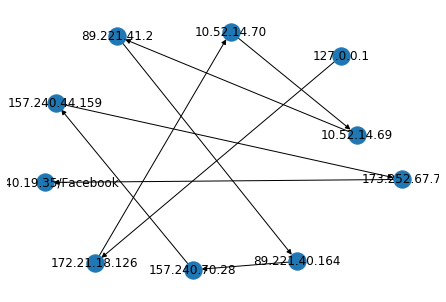

Endpoint:	157.240.19.35/Facebook
Path length:	10
Times used:	1


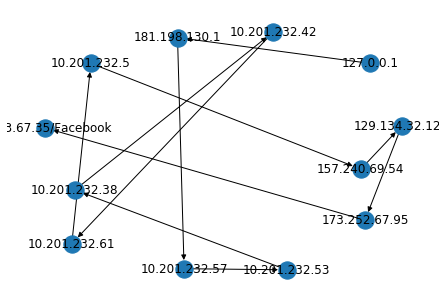

Endpoint:	31.13.67.35/Facebook
Path length:	12
Times used:	33


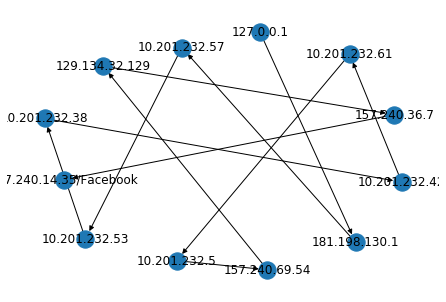

Endpoint:	157.240.14.35/Facebook
Path length:	12
Times used:	16


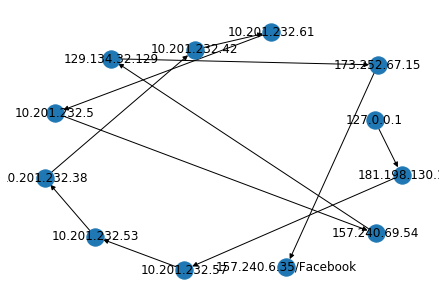

Endpoint:	157.240.6.35/Facebook
Path length:	12
Times used:	6


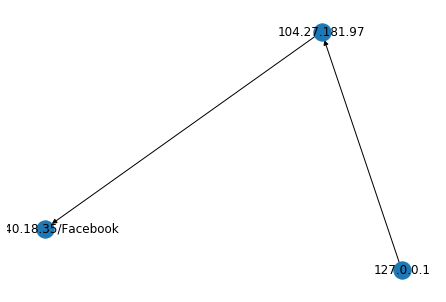

Endpoint:	157.240.18.35/Facebook
Path length:	3
Times used:	2


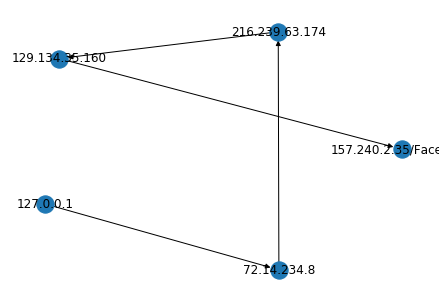

Endpoint:	157.240.2.35/Facebook
Path length:	5
Times used:	1


In [10]:
shortest_paths = []
for ep, times_used in endpoints.items():
    sp = nx.algorithms.shortest_path(G, source=start_ip , target=ep, weight='weight')
    shortest_paths.append(sp)
    sp_G = nx.DiGraph()

    for i in range(len(sp)):
        try:
            sp_G.add_edge(sp[i], sp[i+1], weight=0)
        except:
            #se dibuja el grafo.
            nx.draw(sp_G, with_labels=True)
            #nx.draw_circular(G, with_labels=True)
            plt.show()
            print(f"Endpoint:\t{ep}", f"Path length:\t{len(sp)}", f"Times used:\t{times_used}", sep='\n')

In [49]:
most_used_path = nx.algorithms.shortest_path(G, source=start_ip , target=max(endpoints), weight='weight')

#for ip in path:
for ip in most_used_path:
    ip = ip.split('/')[0]
    r = dbs.HostIP.get(ip)
    if not r.country and not r.region and not r.city and not r.longitude and not r.latitude:
        print(ip, "Private", sep='\t')
    else:
        print(f"\n{ip}\nCtry:\t{r.country if r.country else ''}\nCity:\t{r.city if r.city else ''}\nRegn:\t{r.region if r.region else ''}\nLong:\t{r.longitude if r.longitude else ''}\nLat:\t{r.latitude if r.latitude else ''}\n")

127.0.0.1	Private
181.198.130.1	Private
10.201.232.57	Private
10.201.232.53	Private
10.201.232.38	Private
10.201.232.42	Private
10.201.232.61	Private
10.201.232.5	Private

157.240.69.54
Ctry:	US
City:	
Regn:	
Long:	
Lat:	


129.134.32.127
Ctry:	US
City:	
Regn:	
Long:	
Lat:	

173.252.67.95	Private

31.13.67.35
Ctry:	ID
City:	Jakarta
Regn:	
Long:	106.8
Lat:	-6.26667

